In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns

In [2]:
style.use('fivethirtyeight')
parks = pd.read_csv('./data/CPD_Parks.csv')

# Question

* Which wards have the most park area?
* Are there any factors of the wards that are correlated with park area?

Let's begin by taking a look at the dataset to see what we have available

In [3]:
parks.head()    

,the_geom,PARK_NO,OBJECTID_1,PARK,LOCATION,ZIP,ACRES,WARD,PARK_CLASS,LABEL,...,CROQUET,HANDBALL_I,HARBOR,MODELTRAIN,MODELYACHT,NATURE_BIR,MINIGOLF,PERIMETER,Shape_Leng,Shape_Area
0,MULTIPOLYGON (((-87.64817638700737 41.83972833...,2,1,MCGUANE (JOHN),2901 S POPLAR AVE,60608.0,10.30,11,COMMUNITY PARK,McGuane,...,0,0,0,0,0,0,0,2672.326627,2672.326627,430341.671424
1,MULTIPOLYGON (((-87.632863551078 41.8344952755...,3,2,ARMOUR (PHILIP) SQUARE,3309 S SHIELDS AVE,60616.0,9.05,11,COMMUNITY PARK,Armour Sq,...,0,0,0,0,0,0,0,2484.283006,2484.283006,391095.834054
2,MULTIPOLYGON (((-87.63554759376666 41.81257646...,4,3,FULLER (MELVILLE),331 W 45TH ST,60609.0,11.31,3,COMMUNITY PARK,Fuller,...,0,0,0,0,0,0,0,2878.428150,2878.428150,497076.662367
3,MULTIPOLYGON (((-87.66976347485802 41.80300994...,5,4,CORNELL (PAUL) SQUARE,1809 W 50TH ST,60609.0,8.80,20,COMMUNITY PARK,Cornell Sq,...,0,0,0,0,0,0,0,2462.607598,2462.607598,385672.402254
4,MULTIPOLYGON (((-87.54799250054684 41.74462388...,6,5,RUSSELL (MARTIN) SQUARE,3045 E 83RD ST,60617.0,10.05,10,COMMUNITY PARK,Russell Sq,...,0,0,0,0,0,0,0,2777.375936,2777.375936,435169.113288


In [4]:
# Cleaning up the column names
parks.columns = [column.lower() for column in parks.columns]

I'm curious if the acreage calculation is correct - it looks like we have the number for shape area as well as an acre number. Let's check this out. For reference:

1 Acre = 43560$ft^2$

I'm assuming that `shape_area` is measured in sq. ft because that gets me closest to the acre number, but there is no documentation on this.

In [5]:
# Divide area by 43560 to get the calculated acres
parks['acre_calc'] = parks['shape_area'] / 43560

Now I'll find the error between the posted acreage vs. calculated acreage

In [6]:
# Listed acres minus calculated acres
parks['acre_error'] = parks['acres'] - parks['acre_calc']

If the `acre_error` is positive, that means that the acres listed are higher than the calculated acreage, so further investigation is needed into why the documented acreage is higher than calculated

In [7]:
# Absolute value to be used in total error calculations
parks['abs_acre_error'] = abs(parks['acre_error'])

In [8]:
# Pct error to be used for identifying most drastic errors
parks['pct_acre_error'] = parks['acre_error'] / parks['acre_calc']

In [9]:
Why is there such a large error in the acreage calculation? This isn't a huge deal if it's just a number for record-keeping, but that land is being paid for somewhere.

Things to consider:
* Surveying technology has improved drastically over time, the original acreage may have been calculated decades or centuries ago.
* Assessors may or may not consider streets/sidewalks/pathways/physical structures as usable land in the acre calculations, but this would only account for negative errors

*From [Jonathan Goode at Landthink.com](https://www.landthink.com/discussing-discrepancies-in-acreage/)*

SyntaxError: invalid syntax (<ipython-input-9-04a4b74598a9>, line 1)

parks[['ward', 'shape_area', 'acres', 'acre_calc', 'acre_error', 'pct_acre_error']]

In [10]:
parks.sort_values(by='pct_acre_error', ascending=False)[['ward', 'acres', 'acre_calc', 'acre_error', 'shape_area', 'pct_acre_error']]

,ward,acres,acre_calc,acre_error,shape_area,pct_acre_error
303,3,0.01,0.001240,0.008760,54.019238,7.063794
554,8,0.57,0.319706,0.250294,13926.380758,0.782890
286,20,0.75,0.497034,0.252966,21650.800603,0.508951
221,11,0.71,0.500883,0.209117,21818.476676,0.417496
262,37,6.96,5.125157,1.834843,223251.855959,0.358007
...,...,...,...,...,...,...
484,24,0.16,0.245206,-0.085206,10681.155754,-0.347486
506,24,0.18,0.285923,-0.105923,12454.821888,-0.370461
563,49,0.61,0.970685,-0.360685,42283.028797,-0.371578
424,25,3.76,6.050288,-2.290288,263550.550938,-0.378542


In [11]:
abs(parks['acre_error']).mean()

0.35137733655052683

In [12]:
error_df = pd.DataFrame(columns=['num_parks'])

In [13]:
error_df['avg_acre_error'] = parks.groupby('ward').mean()['acre_error']

In [14]:
error_df['abs_avg_acre_error'] = parks.groupby('ward').mean()['acre_error']

In [15]:
error_df['abs_avg_acre_error'] = abs(error_df['abs_avg_acre_error'])

In [16]:
error_df['num_parks'] = parks.groupby('ward').count()['acre_error']

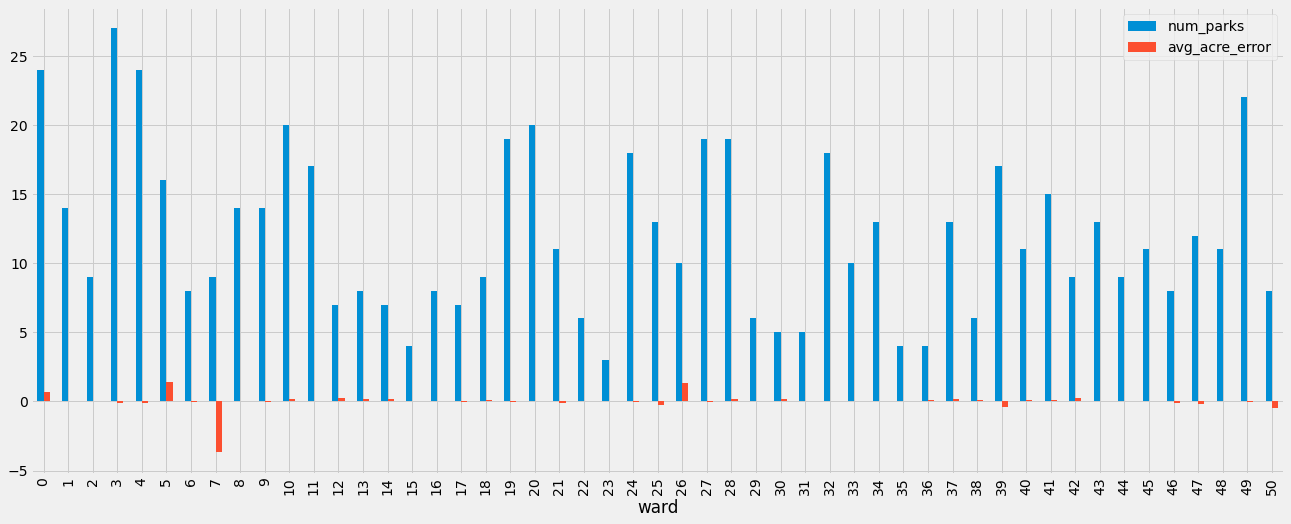

In [17]:
error_df[['num_parks', 'avg_acre_error']].plot(kind='bar', figsize=(20, 8));

Let's look at the top 5 wards ranked by the acre's mean absolute error when comparing actual acreage vs. calculated acreage

In [18]:
error_df.sort_values(by='abs_avg_acre_error', ascending=False).head(5)

,num_parks,avg_acre_error,abs_avg_acre_error
ward,,,
7,9,-3.682938,3.682938
5,16,1.424635,1.424635
26,10,1.357665,1.357665
0,24,0.717121,0.717121
50,8,-0.477914,0.477914


I am most interested in parks where the **calculated acreage is lower than the documented acreage**, this means there is some missing or outdated information, and these miscalculations could be passed on to taxpayers. Let's split our data into groups based on whether the documented acreage is higher or lower than the calculated acreage.

In [23]:
parks['over_calculated_acres'] = np.where(parks['acre_error'] > 0, 1, 0)

In [24]:
parks['over_calculated_acres'].value_counts(normalize=True)

1    0.586319
0    0.413681
Name: over_calculated_acres, dtype: float64

In [25]:
parks.groupby('over_calculated_acres').describe()['acre_error']

,count,mean,std,min,25%,50%,75%,max
over_calculated_acres,,,,,,,,
0,254.0,-0.392258,2.398623,-33.079655,-0.128173,-0.013264,-0.002952,-0.000015
1,360.0,0.322534,1.752596,0.000001,0.004543,0.018818,0.086881,20.980553


In [26]:
parks.groupby('over_calculated_acres').describe()['pct_acre_error']

,count,mean,std,min,25%,50%,75%,max
over_calculated_acres,,,,,,,,
0,254.0,-0.046132,0.090568,-0.893297,-0.046575,-0.012688,-0.002401,-0.000015
1,360.0,0.049541,0.376632,0.000004,0.004729,0.011872,0.029980,7.063794


In [27]:
def num_parks_above_thresh(data, column, threshold):
    return f'{data[data[column] > threshold].shape[0]} parks are above {threshold * 100}% error'

In [28]:
# Getting the number of parks outside a 2% error threshold
num_parks_above_thresh(parks, 'pct_acre_error', 0.02)

'131 parks are above 2.0% error'

In [29]:
# Number of parks outside of a 5% error threshold
num_parks_above_thresh(parks, 'pct_acre_error', 0.05)

'55 parks are above 5.0% error'

In [30]:
# Number of parks outside of a 10% error threshold
num_parks_above_thresh(parks, 'pct_acre_error', 0.10)

'18 parks are above 10.0% error'

In [31]:
# Number of parks outside of a 20% error threshold
num_parks_above_thresh(parks, 'pct_acre_error', 0.20)

'8 parks are above 20.0% error'

In [32]:
# Number of parks outside of a 40% error threshold
num_parks_above_thresh(parks, 'pct_acre_error', 0.40)

'4 parks are above 40.0% error'

## Insights
* 360 (58.6% of total) parks have acres that are higher than the calculated acres
* Of those 360 parks, at least 50% of those parks have a pct_acre_error less than ~1.2%
* 55 parks have a pct_acre_error above 10%

In [47]:
parks_above_2_pct = parks[parks['pct_acre_error'] > .02]

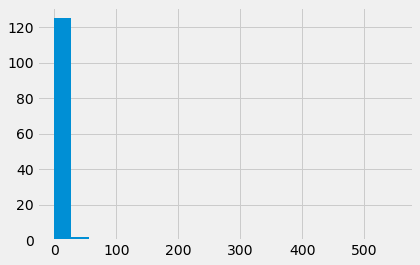

In [48]:
parks_above_2_pct['acres'].hist(bins=20);

In [49]:
parks_above_2_pct['acres'].describe()

count    131.000000
mean      12.154580
std       54.475304
min        0.010000
25%        0.320000
50%        1.020000
75%        5.765000
max      551.520000
Name: acres, dtype: float64

In [51]:
parks_above_2_pct['acre_error'].sum()

72.18116705789667

## For parks with a `pct_acre_error` above 2%:

* **50%** of these parks are **under 1.02 acres** 
* The total error for parks with a `pct_acre_error` above 2% is approximately 72.2 acres

In [52]:
# Creating a variable that will store the wards with the most parks above the 2% error threshold
top_5_wards = list(parks_above_2_pct['ward'].value_counts().head().index)

In [57]:
pd.set_option('max_columns', None)

In [58]:
parks_above_2_pct[parks['ward'].isin(top_5_wards)].sort_values(by='acre_error', ascending=False).head(10)

,the_geom,park_no,objectid_1,park,location,zip,acres,ward,park_class,label,gisobjid,wheelchr_a,archery_ra,artificial,band_shell,baseball_b,basketball,basketba_1,beach,boat_launc,boat_lau_1,boat_slips,bocce_cour,bowling_gr,casting_pi,football_s,community_,conservato,cultural_c,dog_friend,fitness_ce,fitness_co,gallery,garden,golf_cours,golf_drivi,golf_putti,gymnasium,gymnastic_,handball_r,horseshoe_,iceskating,pool_indoo,baseball_j,mountain_b,nature_cen,pool_outdo,zoo,playground,playgrou_1,rowing_clu,volleyball,senior_cen,shuffleboa,skate_park,sled_hill,sport_roll,spray_feat,baseball_s,tennis_cou,track,volleyba_1,water_play,water_slid,boxing_cen,wetland_ar,lagoon,cricket_fi,climbing_w,game_table,carousel,croquet,handball_i,harbor,modeltrain,modelyacht,nature_bir,minigolf,perimeter,shape_leng,shape_area,acre_calc,acre_error,abs_acre_error,pct_acre_error,over_calculated_acres
122,MULTIPOLYGON (((-87.6958265789165 41.861021977...,218,123,DOUGLAS (STEPHEN),1401 S SACRAMENTO DR,60623.0,165.49,0,CITYWIDE PARK,Douglas,215,0,0,2,0,0,8,3,0,0,0,0,0,0,1,5,0,0,1,0,1,0,0,1,1,0,1,1,0,0,0,0,0,1,0,0,1,0,5,0,0,0,0,0,0,0,0,2,1,3,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,18628.536103,18628.536103,7.046674e+06,161.769383,3.720617,3.720617,0.023000,1
364,MULTIPOLYGON (((-87.70917941074364 42.01179047...,538,365,PARK NO. 538,6400 N KEDZIE,60645.0,32.67,0,LINEAR PARK,Park 538,388,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11809.498738,11809.498738,1.292192e+06,29.664637,3.005363,3.005363,0.101311,1
601,MULTIPOLYGON (((-87.66792861219878 41.91433194...,572,597,PARK NO. 572,1601-3701 W BLOOMINGDALE AVE,60647.0,16.76,0,LINEAR PARK,Park 572,5739,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30194.682308,30191.087610,6.281173e+05,14.419590,2.340410,2.340410,0.162308,1
262,MULTIPOLYGON (((-87.72871459692927 41.89519096...,407,263,ORR (REZIN),744 N PULASKI RD,60624.0,6.96,37,COMMUNITY PARK,Orr,301,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2057.891767,2057.891767,2.232519e+05,5.125157,1.834843,1.834843,0.358007,1
21,MULTIPOLYGON (((-87.68232636987031 41.79339287...,22,20,GAGE (GEORGE),2415 W 55TH ST,60629.0,26.50,0,REGIONAL PARK,Gage,14,0,0,1,0,0,2,1,0,0,0,0,0,0,0,2,1,0,0,0,1,0,0,0,0,0,0,2,0,0,0,0,0,3,0,0,1,0,1,0,0,1,0,0,0,0,0,0,2,6,1,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,8414.167647,8414.167647,1.095018e+06,25.138149,1.361851,1.361851,0.054175,1
106,MULTIPOLYGON (((-87.70607314161074 41.97419823...,186,101,RIVER,5100 N FRANCISCO AVE,60625.0,29.60,0,REGIONAL PARK,River,44,0,0,1,0,0,2,1,0,0,2,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,2,0,0,1,0,0,0,0,0,0,1,5,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6677.571017,6677.571017,1.256922e+06,28.854969,0.745031,0.745031,0.025820,1
353,MULTIPOLYGON (((-87.62847808415796 41.78306477...,527,354,PARK NO. 527,6200 S LaSALLE ST,60621.0,5.75,20,UNIMPROVED PARK,Park 527,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2836.394889,2836.394889,2.246674e+05,5.157655,0.592345,0.592345,0.114848,1
357,MULTIPOLYGON (((-87.64995240336955 41.84429506...,531,358,PALMISANO (HENRY),2850 S HALSTED ST,60608.0,27.05,11,COMMUNITY PARK,Palmisano,21,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,4373.059997,4373.059997,1.153109e+06,26.471732,0.578268,0.578268,0.021845,1
365,MULTIPOLYGON (((-87.70720009568268 41.92077905...,539,366,PALMER SQUARE,2200 N KEDZIE AVE,60647.0,8.09,0,COMMUNITY PARK,Palmer Sq,5740,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4067.204319,4067.204319,3.339169e+05,7.665677,0.424323,0.424323,0.055354,1

**6 out of 10** of the parks with the highest acre_error are in ward 0. What does that mean?

## Next steps

Need to investigate why some of these parks have no wards, and contact park supervisors to see why the acreage is higher than the calculated acreage.